<a href="https://colab.research.google.com/github/Shuo-Zh/dl/blob/main/%E8%87%AA%E6%B3%A8%E6%84%8F%E5%8A%9B%E5%92%8CTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 总结
- transformer是一个纯使用注意力的编码器-解码器
- 编码器和解码器 都有n个 transformer块
- 每个块里使用多头（自）注意力，基于未知的前馈网络和层归一化（适用于对于样本的层归一化）

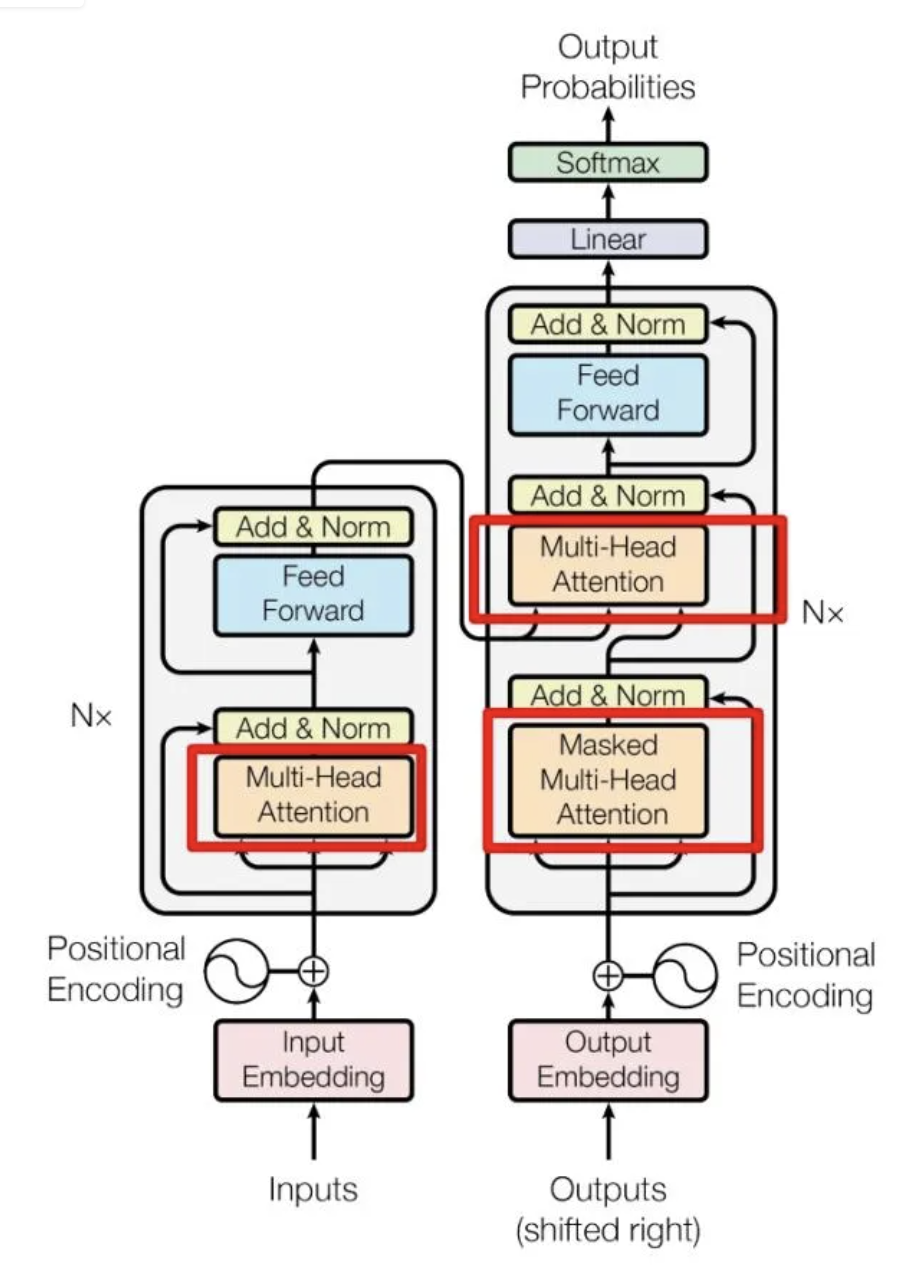

## 自注意力
- 给定序列 x1,..., xn in Rᵈ，一个序列有个长为d的特征
- 自注意力池化层，将xi当成 **key, value, query** 来对序列抽取特征得到 y1,...,yn,这里
 yᵢ = f(xᵢ,(x1,x1) ,..., (xn, xn)) ∈ Rᵈ
- 可以处理序列

## feed forward
两层全连接层，第一层激活函数 Relu，第二层不适用激活函数
max(0, XW1 + b1) W2 + b2

## *位置编码（position embedding）*
- 将位置信息注入到输入里
- 跟 CNN/RNN 不同，自注意力并没有记录位置信息
- 位置编码将位置信息注入到输入里
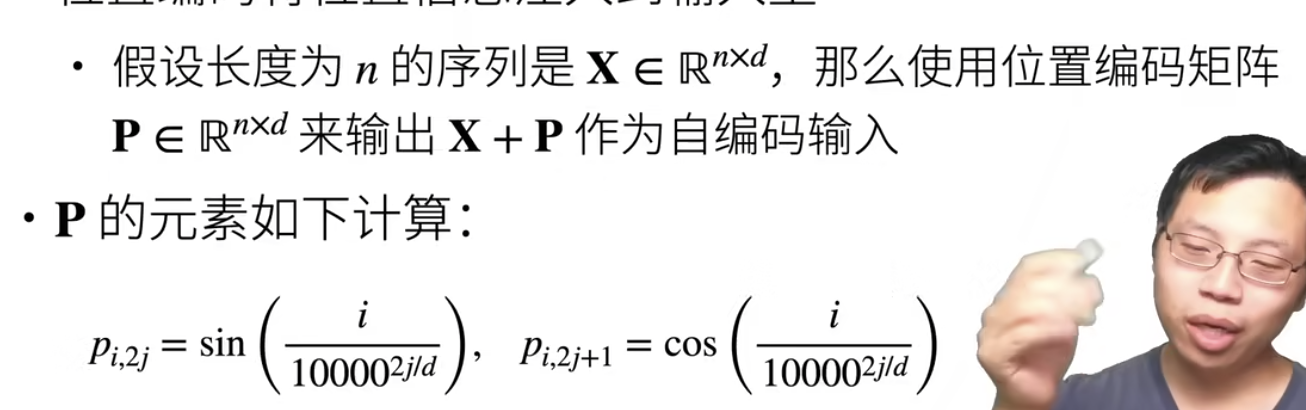

### 相对位置信息-总结
- sin/cos 好处：编码是相对位置信息, i+δ 处的位置编码可以线性投影位置i处的位置编码来表示
  - 记 wⱼ=1/10000\^{2j/d}
- 自注意力层池化层将xᵢ当作 key，value，query来对序列抽取特征
- 完全并行、最长序列为1、但对长序列计算复杂度高
- 位置编码在输入中加入位置信息，使得自注意力能够记忆位置信息


In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, 0.5, num_heads)
attention.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): LazyLinear(in_features=0, out_features=100, bias=True)
  (W_k): LazyLinear(in_features=0, out_features=100, bias=True)
  (W_v): LazyLinear(in_features=0, out_features=100, bias=True)
  (W_o): LazyLinear(in_features=0, out_features=100, bias=True)
)

In [ ]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

In [ ]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

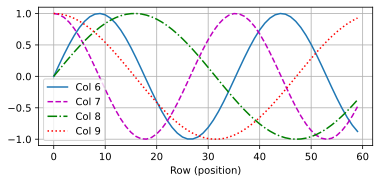

In [ ]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [ ]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


## Transformer
- Encoder-Decoder;
- 全连接；基于位置的前馈网络；
- Residule connection;
- Positional encoding;

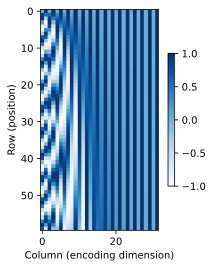

In [ ]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

#### 多头注意力

In [8]:
# class MultiHeadAttention(nn.Block):
#     """多头注意力"""
#     def __init__(self, num_hiddens, num_heads, dropout, use_bias=False,
#                  **kwargs):
#         super(MultiHeadAttention, self).__init__(**kwargs)
#         self.num_heads = num_heads
#         self.attention = d2l.DotProductAttention(dropout)
#         self.W_q = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
#         self.W_k = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
#         self.W_v = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
#         self.W_o = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)

#     def forward(self, queries, keys, values, valid_lens):
#         # queries，keys，values的形状:
#         # (batch_size，查询或者“键－值”对的个数，num_hiddens)
#         # valid_lens　的形状:
#         # (batch_size，)或(batch_size，查询的个数)
#         # 经过变换后，输出的queries，keys，values　的形状:
#         # (batch_size*num_heads，查询或者“键－值”对的个数，
#         # num_hiddens/num_heads)
#         queries = transpose_qkv(self.W_q(queries), self.num_heads)
#         keys = transpose_qkv(self.W_k(keys), self.num_heads)
#         values = transpose_qkv(self.W_v(values), self.num_heads)

#         if valid_lens is not None:
#             # 在轴0，将第一项（标量或者矢量）复制num_heads次，
#             # 然后如此复制第二项，然后诸如此类。
#             valid_lens = valid_lens.repeat(self.num_heads, axis=0)

#         # output的形状:(batch_size*num_heads，查询的个数，
#         # num_hiddens/num_heads)
#         output = self.attention(queries, keys, values, valid_lens)

#         # output_concat的形状:(batch_size，查询的个数，num_hiddens)
#         output_concat = transpose_output(output, self.num_heads)
#         return self.W_o(output_concat)

#### Transformer 串联

### 基于位置的前馈网络
输入X的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，ffn_num_outputs）的输出张量

In [9]:
#单隐藏层的全连接,输入是3维
# 不是不是2维，前面：样本维、后面：feature维
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [13]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
print(ffn(torch.ones((2,3,4)))[0])
print(ffn(torch.ones((2,3,4)))[1])


tensor([[-0.3631,  0.2877, -0.0507, -0.3330,  0.1619,  0.4373,  0.4011, -0.3421],
        [-0.3631,  0.2877, -0.0507, -0.3330,  0.1619,  0.4373,  0.4011, -0.3421],
        [-0.3631,  0.2877, -0.0507, -0.3330,  0.1619,  0.4373,  0.4011, -0.3421]],
       grad_fn=<SelectBackward0>)
tensor([[-0.3631,  0.2877, -0.0507, -0.3330,  0.1619,  0.4373,  0.4011, -0.3421],
        [-0.3631,  0.2877, -0.0507, -0.3330,  0.1619,  0.4373,  0.4011, -0.3421],
        [-0.3631,  0.2877, -0.0507, -0.3330,  0.1619,  0.4373,  0.4011, -0.3421]],
       grad_fn=<SelectBackward0>)


#### 对比不同维度的层归一化和批量归一化的效果

In [14]:
# layer_norm（基于特征） # batch_norm（基于样本）
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1,2],[2,3]],dtype = torch.float32)
print('layer norm:', ln(X),'\nbatch_norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch_norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [15]:
# 使用残差连接和层归一化
class AddNorm(nn.Module):
  def __init__(self, normalized_shape, dropout, **kwargs):
    super(AddNorm, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)
    self.ln = nn.LayerNorm(normalized_shape)

  def forward(self, X, Y): # Y = X进入后的输出 Residule = 输入+输出
    return self.ln(self.dropout(Y) + X)

In [16]:
# 残差连接和层规范化来实现AddNorm类。暂退法也被作为正则化方法使用。
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

#### 实现编码器中的一个层

In [18]:
class EncoderBlock(nn.Module): # self attention + addNorm + self attention + addNorm
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            num_hiddens,num_hiddens,0.5, num_heads)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(
            X, self.attention(X, X, X, valid_lens)) #self attention q/k/v = X
        return self.addnorm2(Y, self.ffn(Y))

#### Transformer编码器的任何层都不会改变其输入的形状


In [19]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(key_size=24, query_size=24, value_size=24, num_hiddens=24, norm_shape=[100, 24],
                           ffn_num_input=24, ffn_num_hiddens=48, num_heads=8, dropout=0.5)
# encoder_blk = EncoderBlock(key_size=24, query_size=24, value_size=24, num_hiddens=24, dropout=0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 100, 24])

#### 编码器

In [20]:
class TransformerEncoder(d2l.Encoder): # num_hiddens(隐藏层大小) -> 得到 num_hiddens 向量
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens # 隐藏层大小
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i), # 存储 position encoding
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args): # X==token
        X = self.pos_encoding( # 先丢embedding层，长为D，D越大，数值越小，position encoding:[-1,1]
            self.embedding(X) * math.sqrt(self.num_hiddens)) # 保证数值差不多大小 for visulization
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens) # sequential
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [29]:
# d2l.MultiHeadAttention(
            # key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            # use_bias)

# 创建一个两层的Transformer编码器
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape
# encoder 输出 --> 放在decoder中

torch.Size([2, 100, 24])

In [30]:
#创建两层transformer编码器
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

# torch.Size([2, 100, 24]) = batch_size = 2 ; 长度 = 100； hidden_size = 24;


torch.Size([2, 100, 24])

In [34]:
# Transformer解码器也是由多个相同的层组成

class DecoderBlock(nn.Module):
    """解码器中第 i 个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i #记录i

        # self.attention1 = d2l.MultiHeadAttention(key_size, query_size,
        #                                          value_size, num_hiddens,
        #                                          num_heads, dropout)

        self.attention1 = d2l.MultiHeadAttention(
                    num_hiddens,num_hiddens,dropout, num_heads)

        self.addnorm1 = AddNorm(norm_shape, dropout)
        # self.attention2 = d2l.MultiHeadAttention(key_size, query_size,
        #                                          value_size, num_hiddens,
        #                                          num_heads, dropout)

        self.attention2 = d2l.MultiHeadAttention(
            num_hiddens,num_hiddens, dropout, num_heads)

        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state): #state: (encoder输出，encoder-valid_lens, 过去的东西） valid_lens for 掩码
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                          device=X.device).repeat(
                                              batch_size, 1)
        else:
            dec_valid_lens = None

        # prediction -- 不需要掩码 training = Q/K/V -- Prediction，累积 Q/K/V
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


In [32]:
#Transformer 解码器
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state # dense layer 做输出

    @property
    def attention_weights(self):
        return self._attention_weights

In [60]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ValueError: ignored

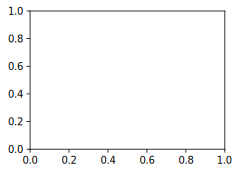

In [61]:
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [37]:
# # 训练
# import matplotlib.pyplot as plt
# num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
# lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
# ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
# key_size, query_size, value_size = 32, 32, 32
# norm_shape = [32]

# train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

# encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
#                              num_hiddens, norm_shape, ffn_num_input,
#                              ffn_num_hiddens, num_heads, num_layers, dropout)
# decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
#                              num_hiddens, norm_shape, ffn_num_input,
#                              ffn_num_hiddens, num_heads, num_layers, dropout)
# net = d2l.EncoderDecoder(encoder, decoder)
# plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['savefig.format'] = 'svg'
# from matplotlib_inline import backend_inline
# backend_inline.set_matplotlib_formats('png')
# import matplotlib as plt
# d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [39]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => recul viens été . battus à battus à battus à,  bleu 0.000
i lost . => recul viens été . battus à battus à battus à,  bleu 0.000
he's calm . => recul ça défaites attrapez ferme-la perdu lâche-toi trouve la sais,  bleu 0.000
i'm home . => recul compris laisse fait perdu lâche-toi trouve la sais battus,  bleu 0.000


In [40]:
# 可视化Transformer 的注意力权重
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 80, 10])

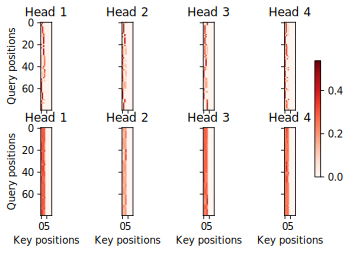

In [41]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

In [45]:
import pandas as pd
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 80, 10]), torch.Size([2, 4, 80, 10]))

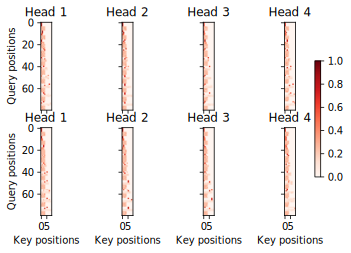

In [46]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

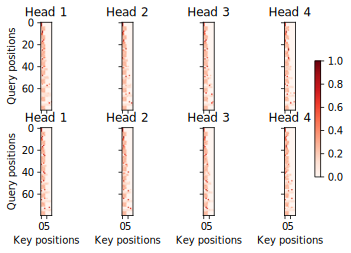

In [47]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))